In [51]:
"""
Notebook-Übersicht:
Dieses Skript zeigt eine vollständige Pipeline für Random Forest
zur Klassifikation (HeartDisease) und Regression (MaxHR)
auf Basis des Heart-Disease-Datensatzes. Dabei wurde ein nur ein Train/Test-Split gemacht
und die Hyperparameter manuell eingestellt. 
"""

"""
Schritt 1: Imports und Plot-Konfiguration

- Lädt alle benötigten Bibliotheken (Pandas, NumPy, Matplotlib, scikit-learn).
- Stellt globale Plot-Einstellungen ein (Figurgröße, Hintergrund-Gitter).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Matplotlib-Standard-Einstellungen für alle Plots
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


In [52]:
"""
Schritt 2: Datensatz laden und ersten Überblick verschaffen

- Lädt den Datensatz 'heart.csv' in ein Pandas DataFrame.
- Gibt die Form des Datensatzes (Anzahl Zeilen, Spalten) aus.
- Listet alle Spaltennamen auf.
- Zeigt pro Spalte die Anzahl fehlender Werte.
- Zeigt die ersten Zeilen des Datensatzes zur Orientierung.
"""

# Datensatz laden (Datei 'heart.csv' muss im gleichen Ordner liegen wie das Notebook)
df = pd.read_csv("heart.csv")

# Überblick über Struktur und fehlende Werte
print("Form des Datensatzes:", df.shape)
print("Spalten:", list(df.columns))
print("\nFehlende Werte pro Spalte:\n", df.isna().sum())

# Erste Zeilen anzeigen
display(df.head())


Form des Datensatzes: (918, 12)
Spalten: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Fehlende Werte pro Spalte:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [53]:
# Features (X) und Zielvariable (y) für die Klassifikation definieren
X_clf = df.drop(columns=["HeartDisease"])
y_clf = df["HeartDisease"]

In [54]:
# Numerische und kategoriale Features bestimmen
numeric_features_clf = X_clf.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_clf = [c for c in X_clf.columns if c not in numeric_features_clf]

print("\nNumerische Features:", numeric_features_clf)
print("Kategoriale Features:", categorical_features_clf)


Numerische Features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Kategoriale Features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [55]:
# Preprocessing-Pipeline:
# - Skaliert numerische Features
# - One-Hot-Encoding für kategoriale Features
preprocess_clf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_clf),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_clf),
    ]
)


In [56]:
# Random Forest Klassifikationsmodell definieren
rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    oob_score=True,
    n_jobs=-1
)

In [57]:
# Gesamt-Pipeline: Preprocessing + Modell
clf_pipeline = Pipeline([
    ("preprocess", preprocess_clf),
    ("model", rf_clf)
])


In [58]:
# Train-Test-Split (stratifiziert nach Zielvariable für ausgewogene Klassen im Test-Set)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [59]:
# Modell trainieren
clf_pipeline.fit(X_train_clf, y_train_clf)

# OOB-Accuracy aus dem Modell-Step holen
oob_acc = clf_pipeline.named_steps["model"].oob_score_


In [60]:

# Train-Accuracy berechnen
y_train_pred = clf_pipeline.predict(X_train_clf)
train_acc = accuracy_score(y_train_clf, y_train_pred)

print("Train-Accuracy:", train_acc)


Train-Accuracy: 1.0


In [61]:
# Vorhersagen (Klassen und Wahrscheinlichkeiten)
y_pred_clf = clf_pipeline.predict(X_test_clf)
y_proba_clf = clf_pipeline.predict_proba(X_test_clf)[:, 1]

In [62]:
# --- Kennzahlen zur Modellbewertung ---
print("\n=== Random Forest Klassifikation ===")
print("Accuracy:", round(accuracy_score(y_test_clf, y_pred_clf), 3))
print("OOB-Accuracy:", oob_acc)
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_clf))




=== Random Forest Klassifikation ===
Accuracy: 0.908
OOB-Accuracy: 0.8542234332425068

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89        82
           1       0.90      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184



Confusion Matrix:
 [[71 11]
 [ 6 96]]


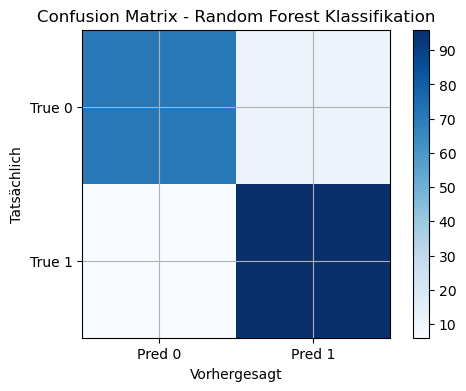

In [63]:
# Confusion Matrix berechnen und ausgeben
cm = confusion_matrix(y_test_clf, y_pred_clf)
print("Confusion Matrix:\n", cm)

# Confusion Matrix visualisieren
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
plt.title("Confusion Matrix - Random Forest Klassifikation")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.show()


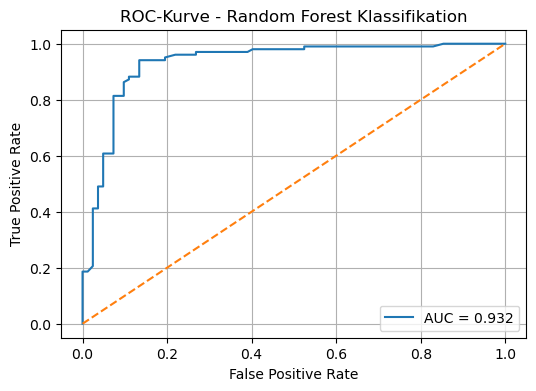

In [64]:
# --- ROC-Kurve & AUC ---
fpr, tpr, _ = roc_curve(y_test_clf, y_proba_clf)
auc = roc_auc_score(y_test_clf, y_proba_clf)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--")  # Diagonale als Zufallsbaseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve - Random Forest Klassifikation")
plt.legend()
plt.show()



Wichtigste Merkmale (Klassifikation):
ST_Slope_Up          0.150972
ST_Slope_Flat        0.099863
Oldpeak              0.095212
MaxHR                0.094792
ChestPainType_ASY    0.092710
Cholesterol          0.091756
Age                  0.069436
RestingBP            0.065353
ExerciseAngina_N     0.051495
ExerciseAngina_Y     0.050639
dtype: float64


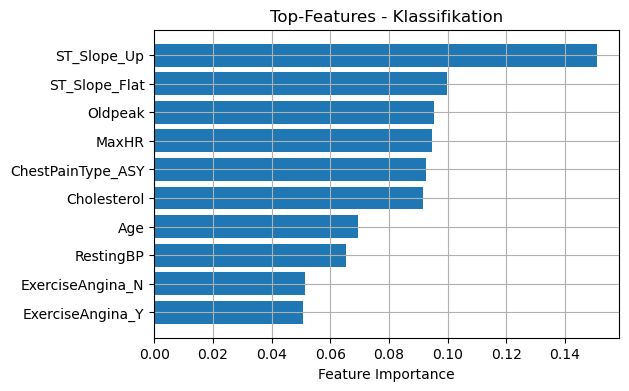

In [65]:
# --- Feature Importances (Wichtigste Merkmale) ---
# Zugriff auf trainiertes Random-Forest-Modell und Preprocessor aus der Pipeline
rf_model_clf = clf_pipeline.named_steps["model"]
pre_clf = clf_pipeline.named_steps["preprocess"]

# One-Hot-encodierte Spaltennamen für kategoriale Features
cat_names = pre_clf.named_transformers_["cat"].get_feature_names_out(categorical_features_clf)

# Gesamtliste der Feature-Namen nach dem Preprocessing
feature_names_clf = numeric_features_clf + cat_names.tolist()

# Wichtigste Features extrahieren und sortieren
importances_clf = (
    pd.Series(rf_model_clf.feature_importances_, index=feature_names_clf)
    .sort_values(ascending=False)
    .head(10)
)

print("\nWichtigste Merkmale (Klassifikation):")
print(importances_clf)

# Balkendiagramm der wichtigsten Features
plt.barh(importances_clf.index, importances_clf.values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top-Features - Klassifikation")
plt.show()


In [66]:
# Features (X) und Zielvariable (y) für die Regression definieren
X_reg = df.drop(columns=["MaxHR"])
y_reg = df["MaxHR"]


In [67]:
# Numerische und kategoriale Features bestimmen
numeric_features_reg = X_reg.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_reg = [c for c in X_reg.columns if c not in numeric_features_reg]

# Preprocessing-Pipeline für die Regression
preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_reg),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_reg),
    ]
)


In [68]:
# Random Forest Regressionsmodell definieren
rf_reg = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

In [69]:
# Gesamt-Pipeline: Preprocessing + Modell
reg_pipeline = Pipeline([
    ("preprocess", preprocess_reg),
    ("model", rf_reg)
])

In [70]:
# Train-Test-Split für die Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [71]:
# Modell trainieren
reg_pipeline.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'Oldpeak', 'HeartDisease']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 RandomForestRegressor(n_estimators=400, n_jobs=-1,
                                       random_state=42))])

In [72]:
# Vorhersagen auf dem Test-Set
y_pred_reg = reg_pipeline.predict(X_test_reg)

In [73]:
# --- Regressionskennzahlen ---
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n=== Random Forest Regression (MaxHR) ===")
print("MSE:", mse)
print("RMSE:", round(rmse, 3))
print("R²:", round(r2, 3))


=== Random Forest Regression (MaxHR) ===
MSE: 489.1754246263587
RMSE: 22.117
R²: 0.266


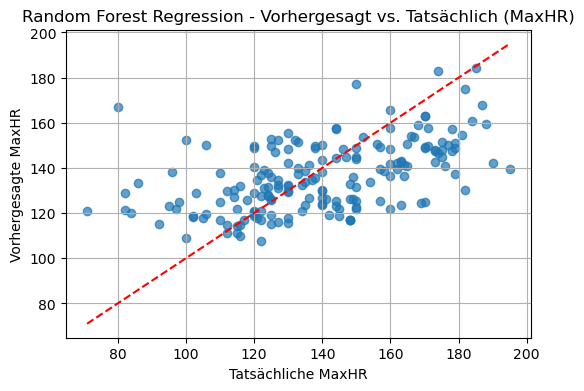

In [74]:
# Scatterplot: tatsächliche vs. vorhergesagte Werte
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7)
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    "r--"
)
plt.xlabel("Tatsächliche MaxHR")
plt.ylabel("Vorhergesagte MaxHR")
plt.title("Random Forest Regression - Vorhergesagt vs. Tatsächlich (MaxHR)")
plt.show()


In [75]:
# --- Feature Importances für die Regression ---
rf_model_reg = reg_pipeline.named_steps["model"]
pre_reg = reg_pipeline.named_steps["preprocess"]


Wichtigste Merkmale (Regression):
Age                  0.210906
Cholesterol          0.169875
RestingBP            0.125783
HeartDisease         0.114703
Oldpeak              0.086788
ST_Slope_Up          0.062016
ChestPainType_ASY    0.032171
ExerciseAngina_N     0.029827
ExerciseAngina_Y     0.027415
RestingECG_LVH       0.021512
dtype: float64


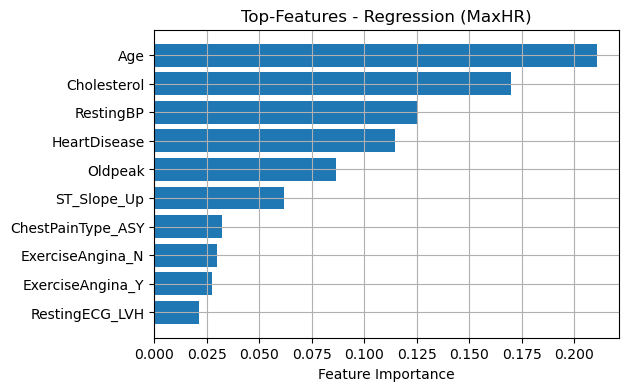

In [76]:
# One-Hot-encodierte Spaltennamen für kategoriale Features
cat_names_reg = pre_reg.named_transformers_["cat"].get_feature_names_out(categorical_features_reg)

# Gesamtliste der Feature-Namen nach dem Preprocessing
feature_names_reg = numeric_features_reg + cat_names_reg.tolist()

# Wichtigste Features extrahieren und sortieren
importances_reg = (
    pd.Series(rf_model_reg.feature_importances_, index=feature_names_reg)
    .sort_values(ascending=False)
    .head(10)
)
print("\nWichtigste Merkmale (Regression):")
print(importances_reg)

# Balkendiagramm der wichtigsten Regressionsfeatures
plt.barh(importances_reg.index, importances_reg.values)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top-Features - Regression (MaxHR)")
plt.show()
